In [ ]:
## Only trained on the paris data for now with 25 epochs

# Model Part

In [ ]:
# 1 minute
!kaggle datasets download ollibolli/spacenet-3

Dataset URL: https://www.kaggle.com/datasets/ollibolli/spacenet-3
License(s): unknown
100% 9.40G/9.41G [01:36<00:00, 111MB/s] 
100% 9.41G/9.41G [01:36<00:00, 104MB/s]


In [ ]:
# 3 minutes
!unzip /content/spacenet-3.zip -d /content/spacenet-3

Streaming output truncated to the last 5000 lines.
  inflating: /content/spacenet-3/8bit/Khartoum/mask/SN3_roads_train_AOI_5_Khartoum_PS-RGB_img92.png  
  inflating: /content/spacenet-3/8bit/Khartoum/mask/SN3_roads_train_AOI_5_Khartoum_PS-RGB_img93.png  
  inflating: /content/spacenet-3/8bit/Khartoum/mask/SN3_roads_train_AOI_5_Khartoum_PS-RGB_img94.png  
  inflating: /content/spacenet-3/8bit/Khartoum/mask/SN3_roads_train_AOI_5_Khartoum_PS-RGB_img95.png  
  inflating: /content/spacenet-3/8bit/Khartoum/mask/SN3_roads_train_AOI_5_Khartoum_PS-RGB_img97.png  
  inflating: /content/spacenet-3/8bit/Khartoum/mask/SN3_roads_train_AOI_5_Khartoum_PS-RGB_img98.png  
  inflating: /content/spacenet-3/8bit/Paris/images/SN3_roads_train_AOI_3_Paris_PS-RGB_img10.tif  
  inflating: /content/spacenet-3/8bit/Paris/images/SN3_roads_train_AOI_3_Paris_PS-RGB_img100.tif  
  inflating: /content/spacenet-3/8bit/Paris/images/SN3_roads_train_AOI_3_Paris_PS-RGB_img101.tif  
  inflating: /content/spacenet-3/8bit/Par

In [ ]:
!rm -rf /content/spacenet-3.zip

In [ ]:
tiff_path = '/content/spacenet-3/8bit/Paris/images'
mask_path = '/content/spacenet-3/8bit/Paris/mask'
sample_tiff_path = '/content/spacenet-3/8bit/Paris/images/SN3_roads_train_AOI_3_Paris_PS-RGB_img168.tif'
sample_mask_path = '/content/spacenet-3/8bit/Paris/mask/SN3_roads_train_AOI_3_Paris_PS-RGB_img168.png'

In [ ]:
# !pip install segmentation-models-pytorch albumentations rasterio opencv-python

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import rasterio
from PIL import Image
import albumentations as A
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import segmentation_models_pytorch as smp

# Configuration
tiff_path = '/content/spacenet-3/8bit/Paris/images'
mask_path = '/content/spacenet-3/8bit/Paris/mask'
sample_tiff_path = '/content/spacenet-3/8bit/Paris/images/SN3_roads_train_AOI_3_Paris_PS-RGB_img168.tif'
sample_mask_path = '/content/spacenet-3/8bit/Paris/mask/SN3_roads_train_AOI_3_Paris_PS-RGB_img168.png'

BATCH_SIZE = 4
IMG_SIZE = 256
EPOCHS = 25
LR = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and pair image paths
image_files = sorted([os.path.join(tiff_path, f) for f in os.listdir(tiff_path) if f.endswith('.tif')])
mask_files = sorted([os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith('.png')])

# Train-Val-Test Split
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.1, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.1, random_state=42)

# Augmentations
train_transform = A.Compose([
    A.RandomCrop(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

val_transform = A.Compose([A.CenterCrop(IMG_SIZE, IMG_SIZE)])

# Dataset Class
class RoadDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image
        with rasterio.open(self.image_paths[idx]) as src:
            img = src.read().transpose(1, 2, 0).astype(np.float32) / 255.0

        # Read mask
        mask = np.array(Image.open(self.mask_paths[idx])) / 255.0
        mask = mask.astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        img = torch.from_numpy(img).permute(2, 0, 1)
        mask = torch.from_numpy(mask).unsqueeze(0)
        return img.to(device), mask.to(device)

# Create DataLoaders
train_dataset = RoadDataset(train_images, train_masks, train_transform)
val_dataset = RoadDataset(val_images, val_masks, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Model Setup
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid'
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=False)
bce_loss = nn.BCELoss()

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)

        # Calculate both losses
        loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop similarly
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            outputs = model(images)
            loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")



Epoch 1/25 | Train Loss: 1.2380 | Val Loss: 1.1869
Epoch 2/25 | Train Loss: 1.0368 | Val Loss: 1.0653
Epoch 3/25 | Train Loss: 0.9971 | Val Loss: 0.8924
Epoch 4/25 | Train Loss: 0.8869 | Val Loss: 0.8753
Epoch 5/25 | Train Loss: 0.8522 | Val Loss: 0.8097
Epoch 6/25 | Train Loss: 0.7968 | Val Loss: 0.7453
Epoch 7/25 | Train Loss: 0.7881 | Val Loss: 0.6888
Epoch 8/25 | Train Loss: 0.7328 | Val Loss: 0.7103
Epoch 9/25 | Train Loss: 0.6758 | Val Loss: 0.5901
Epoch 10/25 | Train Loss: 0.6359 | Val Loss: 0.6060
Epoch 11/25 | Train Loss: 0.6746 | Val Loss: 0.5890
Epoch 12/25 | Train Loss: 0.6549 | Val Loss: 0.5419
Epoch 13/25 | Train Loss: 0.6154 | Val Loss: 0.5992
Epoch 14/25 | Train Loss: 0.6343 | Val Loss: 0.5616
Epoch 15/25 | Train Loss: 0.6072 | Val Loss: 0.5692
Epoch 16/25 | Train Loss: 0.6522 | Val Loss: 0.4755
Epoch 17/25 | Train Loss: 0.6333 | Val Loss: 0.5661
Epoch 18/25 | Train Loss: 0.5727 | Val Loss: 0.5333
Epoch 19/25 | Train Loss: 0.5652 | Val Loss: 0.5958
Epoch 20/25 | Train L

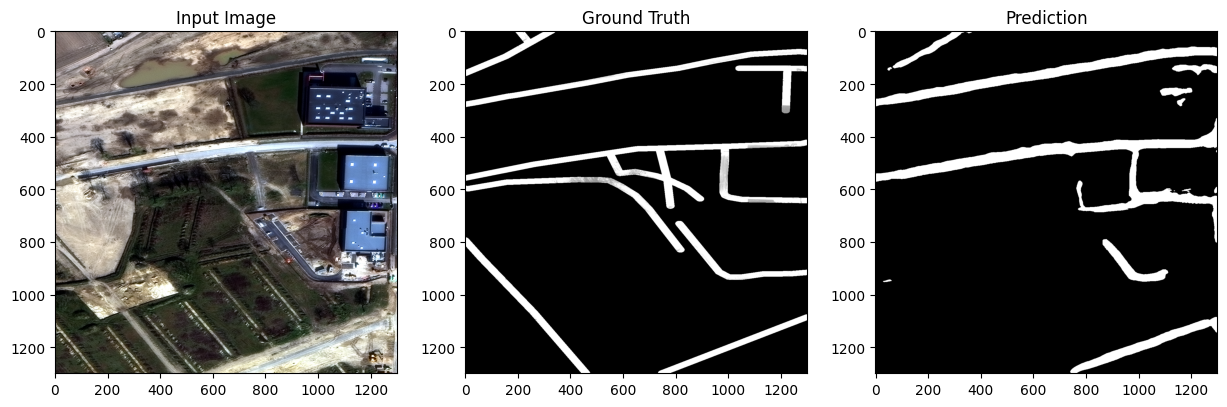

IoU Score: 0.4122


In [ ]:
sample_tiff_path = '/content/spacenet-3/8bit/Khartoum/images/SN3_roads_train_AOI_5_Khartoum_PS-RGB_img87.tif'
sample_mask_path = '/content/spacenet-3/8bit/Khartoum/mask/SN3_roads_train_AOI_5_Khartoum_PS-RGB_img87.png'
sample_tiff_path = '/content/spacenet-3/8bit/Paris/images/SN3_roads_train_AOI_3_Paris_PS-RGB_img10.tif'
sample_mask_path = '/content/spacenet-3/8bit/Paris/mask/SN3_roads_train_AOI_3_Paris_PS-RGB_img10.png'
# Inference Function
def predict(image_path):
    # Read and preprocess
    with rasterio.open(image_path) as src:
        img = src.read().transpose(1, 2, 0).astype(np.float32) / 255.0
    h, w = img.shape[:2]

    # Calculate padding needed
    pad_h = (32 - h % 32) if h % 32 != 0 else 0
    pad_w = (32 - w % 32) if w % 32 != 0 else 0

    # Pad image using reflection padding
    padded_img = cv2.copyMakeBorder(img,
                                   top=0,
                                   bottom=pad_h,
                                   left=0,
                                   right=pad_w,
                                   borderType=cv2.BORDER_REFLECT_101)

    # Convert to tensor
    img_tensor = torch.from_numpy(padded_img).permute(2, 0, 1).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        pred = model(img_tensor).squeeze().cpu().numpy()

    # Remove padding
    pred = pred[:h, :w]

    # Postprocess
    pred = (pred > 0.5).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    pred = cv2.morphologyEx(pred, cv2.MORPH_OPEN, kernel)
    return pred

# Test on Sample Image
pred_mask = predict(sample_tiff_path)
true_mask = np.array(Image.open(sample_mask_path))

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(15,5))
with rasterio.open(sample_tiff_path) as src:
    img = src.read().transpose(1, 2, 0)

ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[1].imshow(true_mask, cmap='gray')
ax[1].set_title('Ground Truth')
ax[2].imshow(pred_mask, cmap='gray')
ax[2].set_title('Prediction')
plt.show()

# Calculate IoU
iou = np.sum((pred_mask > 127) & (true_mask > 127)) / np.sum((pred_mask > 127) | (true_mask > 127))
print(f"IoU Score: {iou:.4f}")